In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
#     for filename in filenames:
        
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/lgg-mri-segmentation
/kaggle/input/lgg-mri-segmentation/kaggle_3m
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7475_19970918
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7684_19950816
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7694_19950404
/kaggle/input/lgg-mri-segmentation/

In [2]:
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import (Image, ImageDraw, ImageFont)
import cv2

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (Input, Conv2D,
                                     Activation, BatchNormalization,
                                     MaxPooling2D, Conv2DTranspose,
                                     concatenate)
from tensorflow.keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
train_files = []
pat_names = []
mask_files = glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for file in mask_files:
    train_files.append(file.replace('_mask',''))
    pat_names.append(file.rsplit('/', -1)[-2])

In [5]:
print("train files")
print(train_files[:5])
print("mask files")
print(mask_files[:5])
print("patient names")
print(pat_names[:5])

train files
['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif']
mask files
['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33_mask.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_1986030

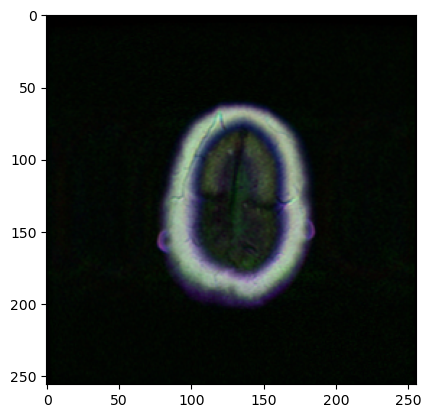

In [6]:
img = Image.open(train_files[10])
plt.imshow(img)

In [7]:
df = pd.DataFrame({
                    'patient':pat_names,
                    'image_path':train_files,
                    'mask_path':mask_files})
df.sample(5)

patient  \
1466  TCGA_HT_7881_19981015   
1824  TCGA_CS_4942_19970222   
2111  TCGA_CS_5397_20010315   
2368  TCGA_DU_6405_19851005   
798   TCGA_HT_A5RC_19990831   

                                             image_path  \
1466  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1824  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2111  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2368  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
798   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  
1466  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1824  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2111  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2368  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
798   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [8]:
np.max(cv2.imread(df['mask_path'][2]))

255

In [9]:
def check_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value>0:
        return 1
    else:
        return 0

In [10]:
df['diagnosis'] = df['mask_path'].apply(lambda x:check_diagnosis(x))

In [11]:
df.sample(3)

patient  \
511   TCGA_DU_A5TR_19970726   
466   TCGA_HT_7694_19950404   
2183  TCGA_DU_6404_19850629   

                                             image_path  \
511   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
466   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2183  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  diagnosis  
511   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
466   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          1  
2183  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0

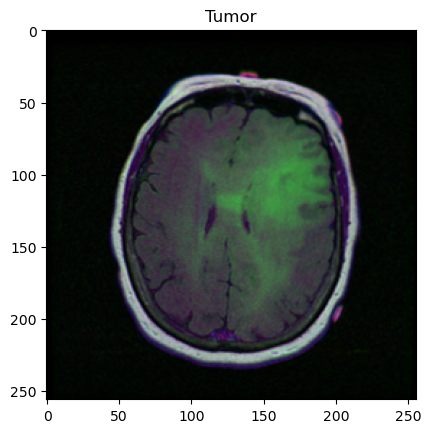

In [12]:
img_ = Image.open(df.iloc[2]['image_path'])
plt.title('Tumor')
plt.imshow(img_)

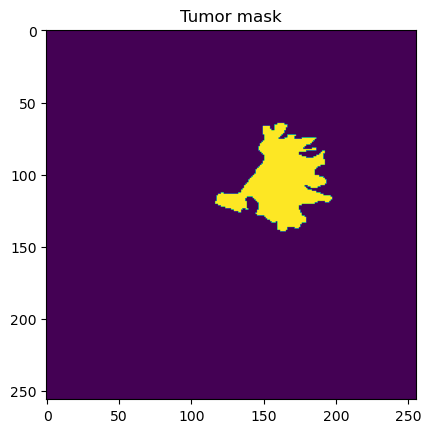

In [13]:
img = Image.open(df.iloc[2]['mask_path'])
plt.title('Tumor mask')
plt.imshow(img)

In [14]:
sample_diag_images = df[df['diagnosis']==1].sample(6)
sample_diag_images

patient  \
1278  TCGA_HT_7879_19981009   
2496  TCGA_FG_7634_20000128   
2914  TCGA_HT_7877_19980917   
1426  TCGA_HT_7881_19981015   
1202  TCGA_HT_8111_19980330   
2570  TCGA_HT_7602_19951103   

                                             image_path  \
1278  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2496  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2914  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1426  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1202  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2570  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  diagnosis  
1278  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          1  
2496  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          1  
2914  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          1  
1426  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          1  
1202  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          1  
2570  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          1

In [15]:
for index, row in sample_diag_images.iterrows():
    print(f"{row['patient']}-\t{row['image_path']}-\t{row['mask_path']}")

TCGA_HT_7879_19981009-	/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_14.tif-	/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_14_mask.tif
TCGA_FG_7634_20000128-	/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_27.tif-	/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_27_mask.tif
TCGA_HT_7877_19980917-	/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_22.tif-	/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_22_mask.tif
TCGA_HT_7881_19981015-	/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_33.tif-	/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_33_mask.tif
TCGA_HT_8111_19980330-	/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_14.t

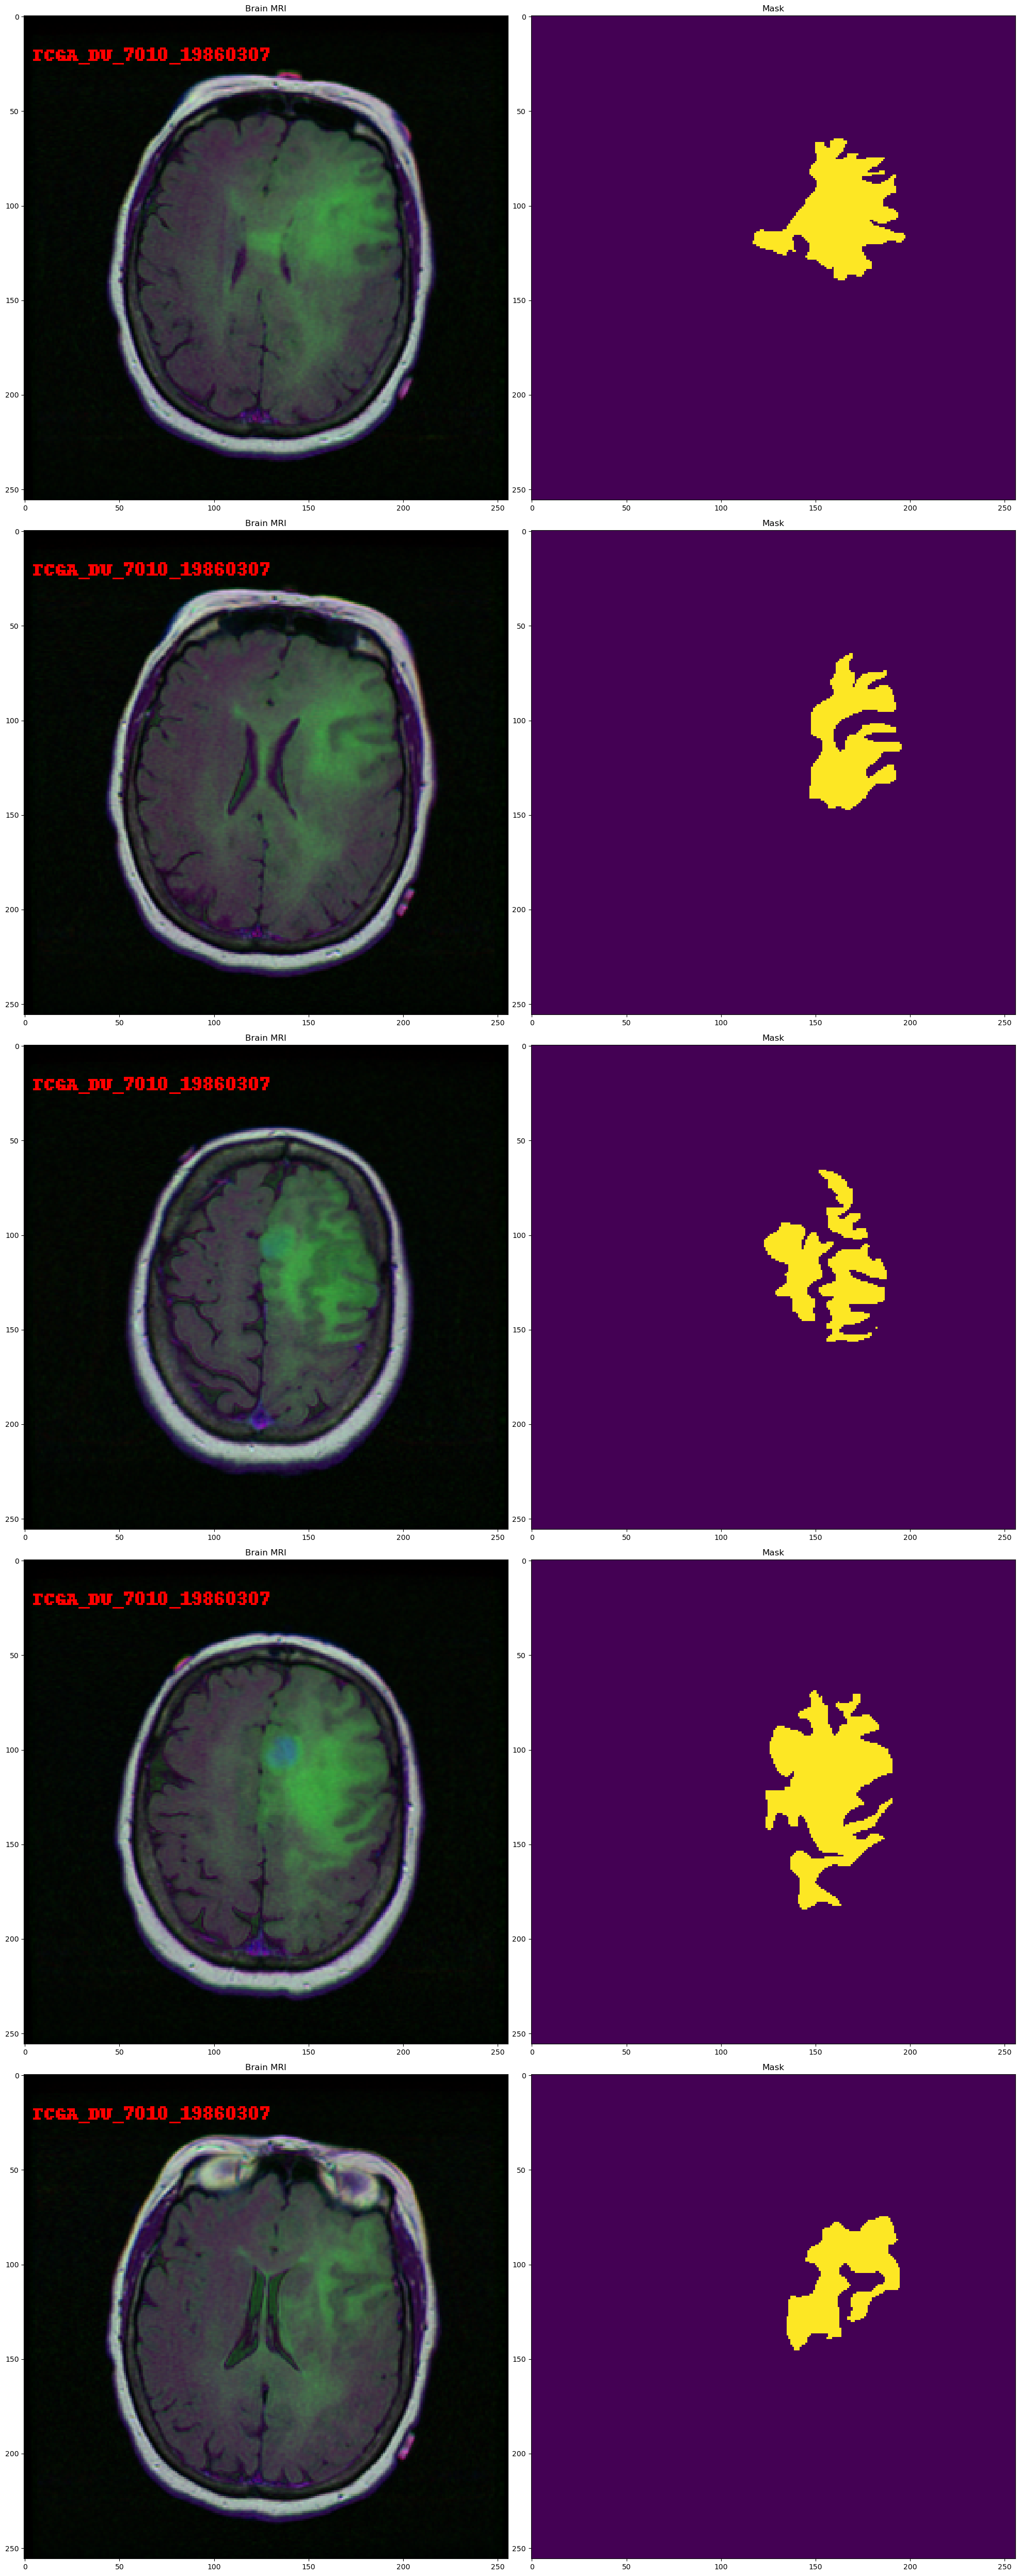

In [16]:
count = 0

fig, axs = plt.subplots(5, 2, figsize = (20, 50))
for i in range(len(df)):
    if df['diagnosis'][i] == 1 and count <5:
        img = Image.open(df.image_path[i])
        axs[count][0].title.set_text('Brain MRI')
        #
        I1 = ImageDraw.Draw(img)
        # Add Text to an image
        I1.text((5, 15), df.loc[i]['patient'], fill=(255, 0, 0))
        #
        axs[count][0].imshow(img)
        
        mask = Image.open(df.mask_path[i])
        axs[count][1].title.set_text('Mask')
        axs[count][1].imshow(mask)
        
        count+=1
        
fig.tight_layout()

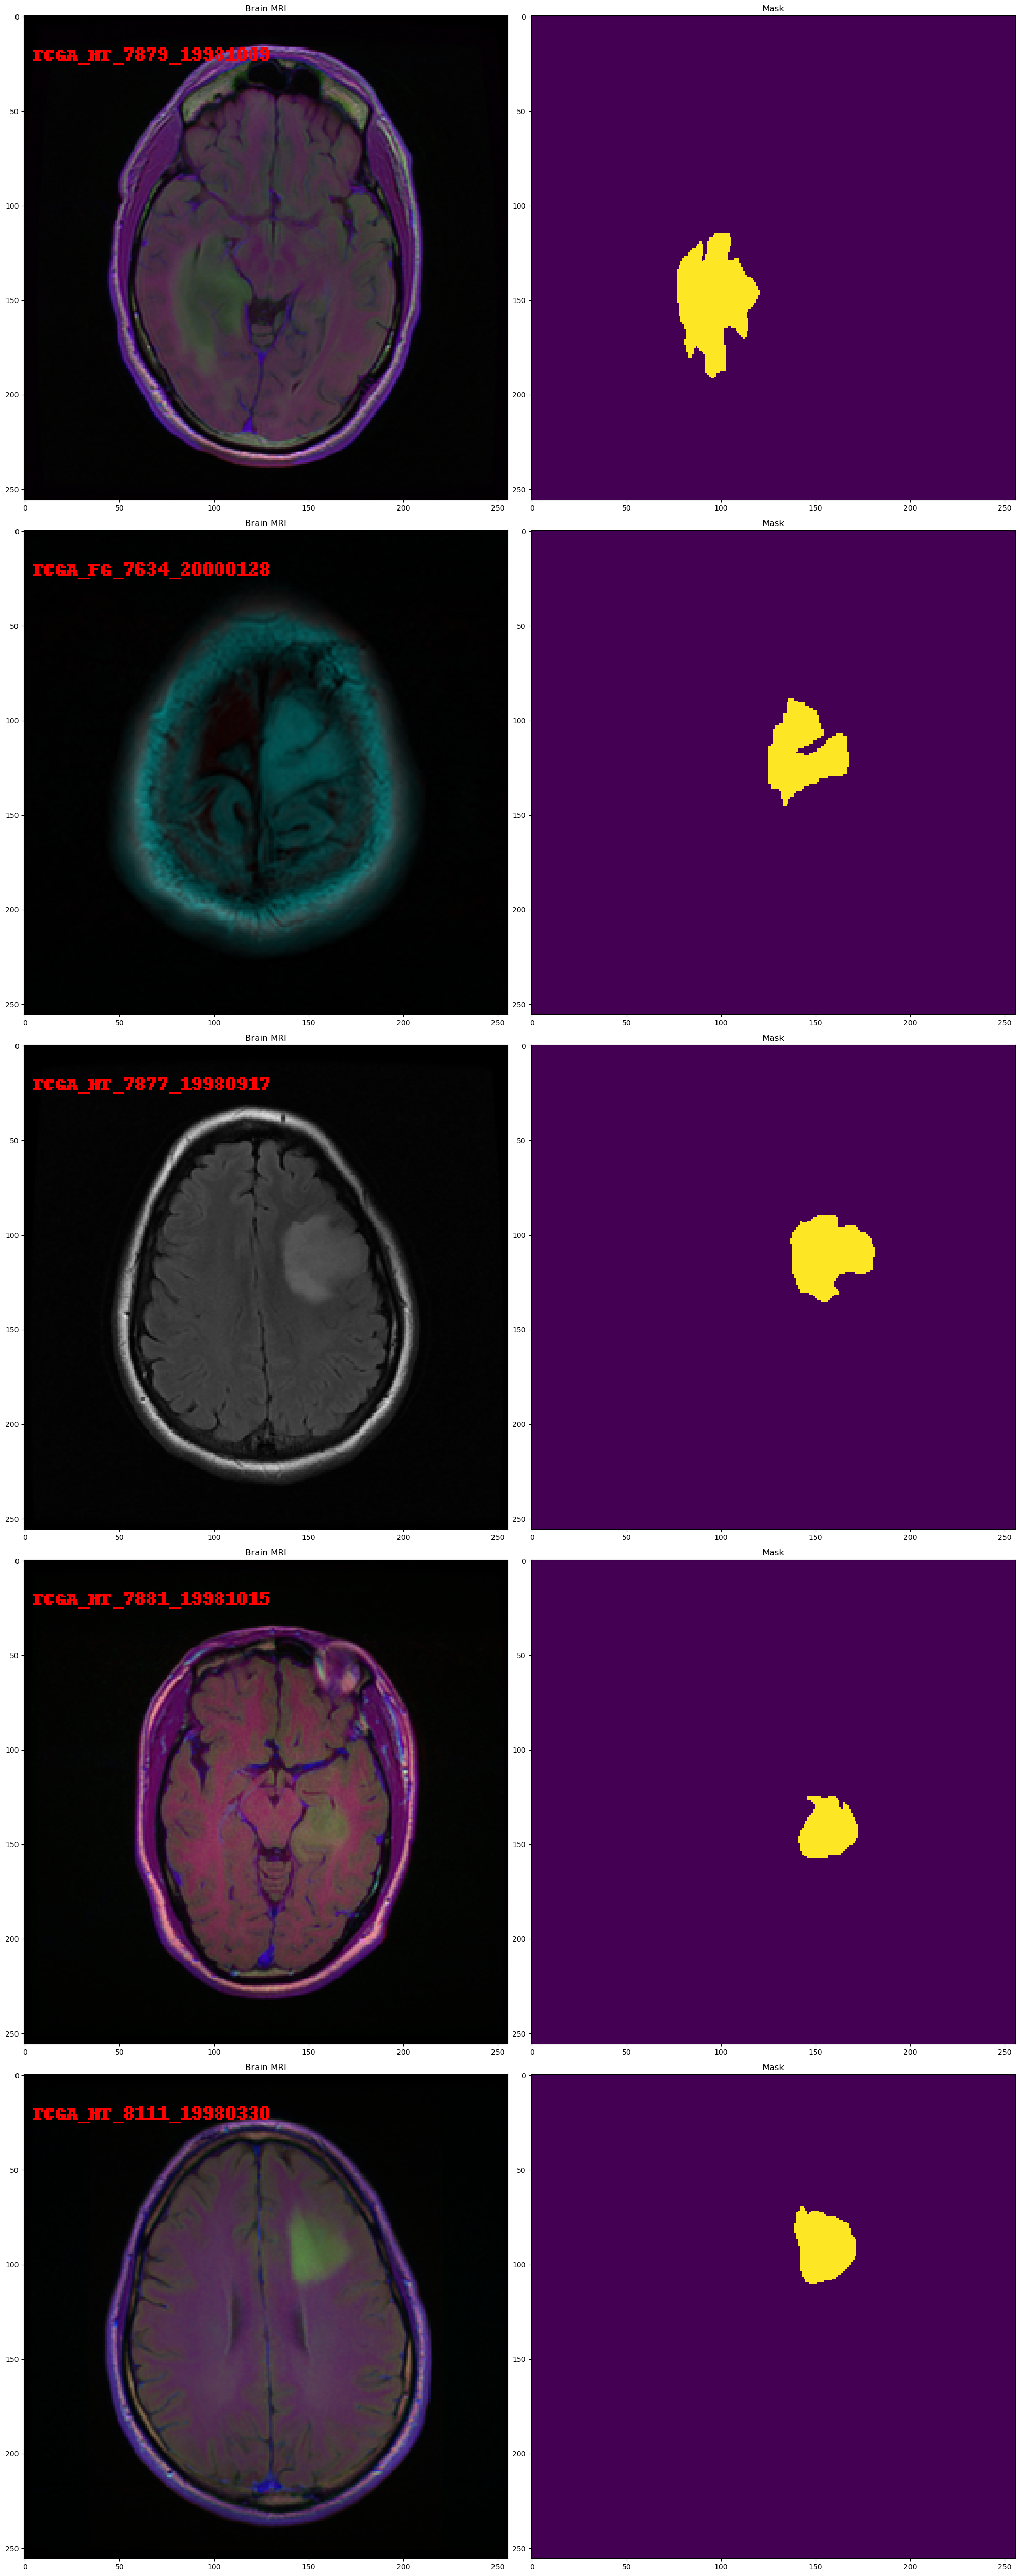

In [17]:
count = 0

fig, axs = plt.subplots(5, 2, figsize = (20, 50))
for i in range(len(sample_diag_images)):
    if count <5:
        img = Image.open(sample_diag_images['image_path'].values[i])
        axs[count][0].title.set_text('Brain MRI')
        #
        I1 = ImageDraw.Draw(img)
        font = ImageFont.load_default()
        # Add Text to an image
        I1.text((5, 15), sample_diag_images['patient'].values[i], fill=(255, 0, 0), font=font)
        #
        axs[count][0].imshow(img)
        
        mask = Image.open(sample_diag_images['mask_path'].values[i])
        axs[count][1].title.set_text('Mask')
        axs[count][1].imshow(mask)
        
        count+=1
        
fig.tight_layout()

In [18]:
df['diagnosis'].value_counts()

0    2556
1    1373
Name: diagnosis, dtype: int64

In [19]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = 42)
df_train, df_val = train_test_split(df_train, test_size = 0.1, random_state = 42)
print(f"train data shape:{df_train.values.shape}\n")
print(f"val data shape:{df_val.values.shape}\n")
print(f"test data shape:{df_test.values.shape}")

train data shape:(3182, 4)

val data shape:(354, 4)

test data shape:(393, 4)


In [20]:
def train_img_generator(data_frame, batch_size, aug_dict,
        image_color_mode='rgb',
        mask_color_mode='grayscale',
        image_save_prefix='image',
        mask_save_prefix='mask',
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = 'image_path',
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = 'mask_path',
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [21]:
BATCH_SIZE = 32

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_img_generator(df_train.iloc[:,1:3], BATCH_SIZE,
                                train_generator_args,
                                target_size=(256, 256))
    
val_gen = train_img_generator(df_val.iloc[:,1:3], BATCH_SIZE,
                                dict(),
                                target_size=(256, 256))

test_gen = train_img_generator(df_test.iloc[:,1:3], BATCH_SIZE,
                                dict(),
                                target_size=(256, 256))

In [22]:
smooth=100
# defining metrics and loss functions
def dice_coef(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    And = K.sum(y_truef * y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    return - iou(y_true, y_pred)

In [23]:
def unet_model(input_size=(256,256,3)):
    '''U-net'''
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])
     

In [24]:
model = unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

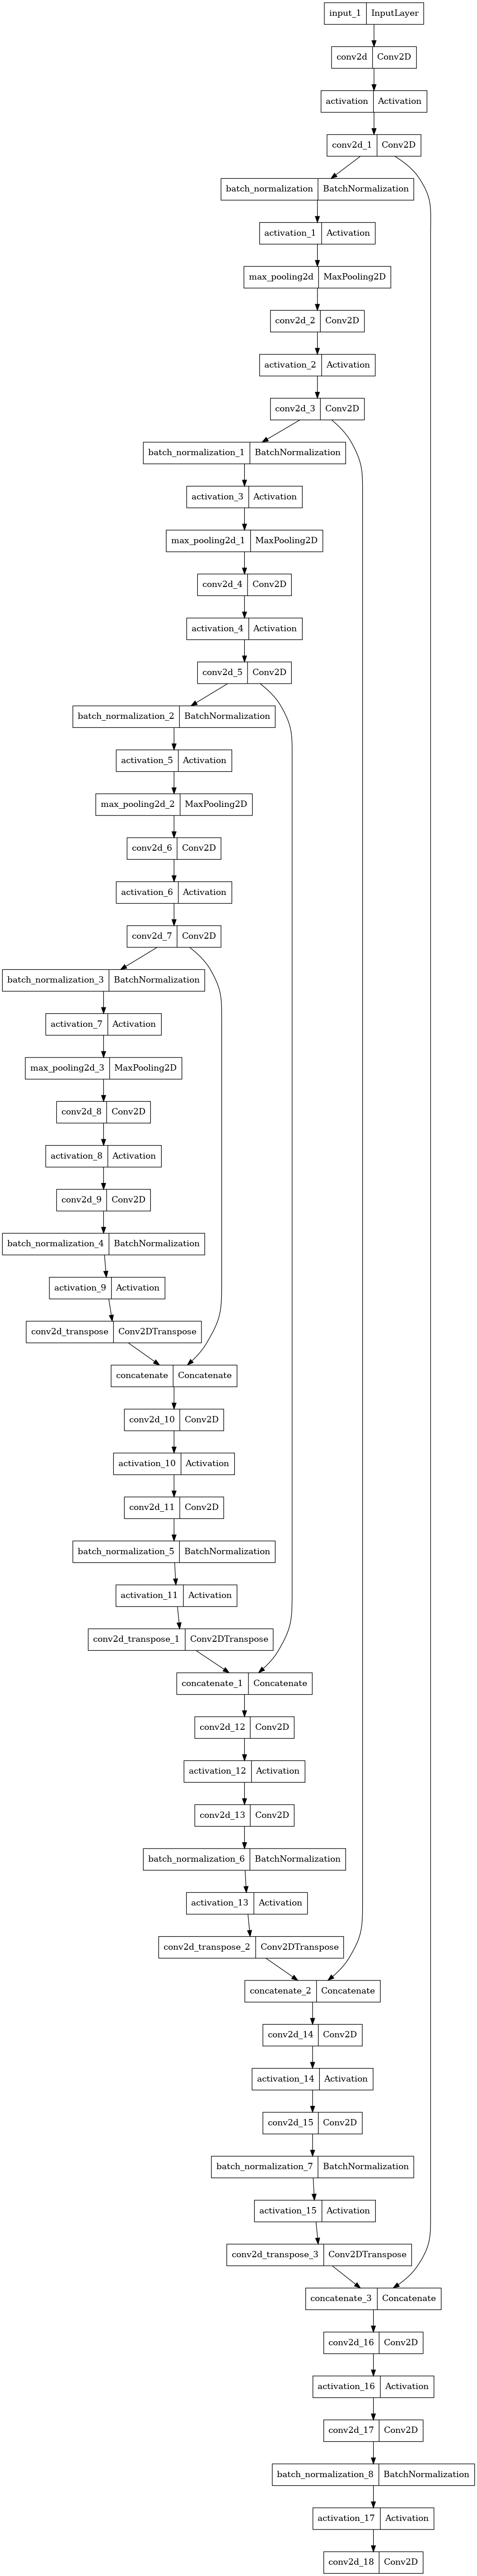

In [25]:
plot_model(model)

In [26]:
EPOCHS = 50
learning_rate = 1e-4

decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=['binary_accuracy', iou, dice_coef])

# callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]
callback = EarlyStopping(monitor='binary_accuracy', patience=3)

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=callback,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 3182 validated image filenames.
Found 3182 validated image filenames.
Epoch 1/50
100/99 [==============================] - ETA: 0s - loss: -0.0828 - binary_accuracy: 0.8776 - iou: 0.0439 - dice_coef: 0.0831Found 354 validated image filenames.
Found 354 validated image filenames.
99/99 [==============================] - 110s 986ms/step - loss: -0.0828 - binary_accuracy: 0.8776 - iou: 0.0439 - dice_coef: 0.0831 - val_loss: -0.0304 - val_binary_accuracy: 0.2334 - val_iou: 0.0143 - val_dice_coef: 0.0281
Epoch 2/50
99/99 [==============================] - 89s 901ms/step - loss: -0.1347 - binary_accuracy: 0.9779 - iou: 0.0727 - dice_coef: 0.1344 - val_loss: -0.0241 - val_binary_accuracy: 0.9870 - val_iou: 0.0118 - val_dice_coef: 0.0226
Epoch 3/50
99/99 [==============================] - 89s 899ms/step - loss: -0.0552 - binary_accuracy: 0.8506 - iou: 0.0287 - dice_coef: 0.0553 - val_loss: -0.0263 - val_binary_accuracy: 0.1328 - val_iou: 0.0124 - val_dice_coef: 0.0243
Epoch 4/50
99/99 [=

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


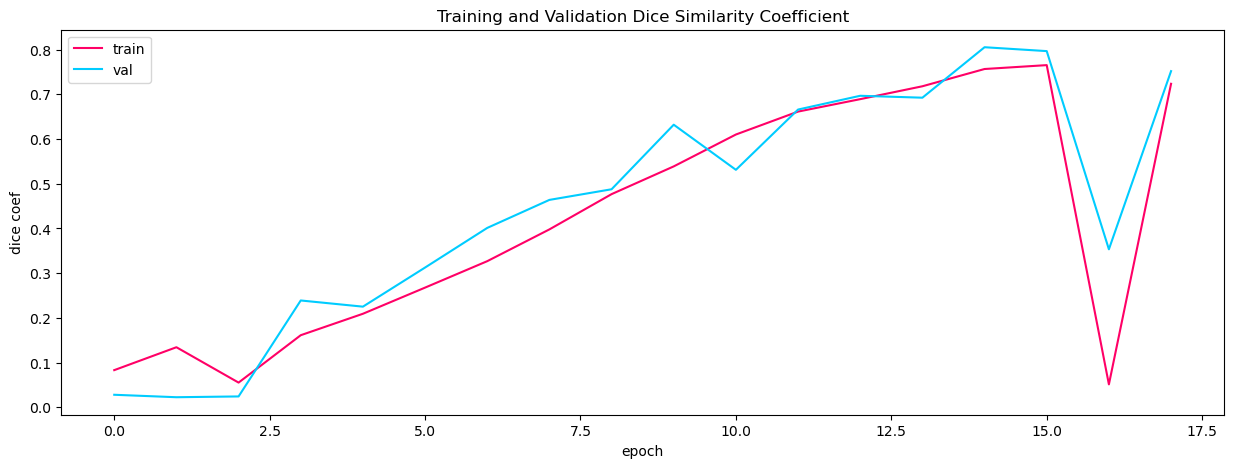

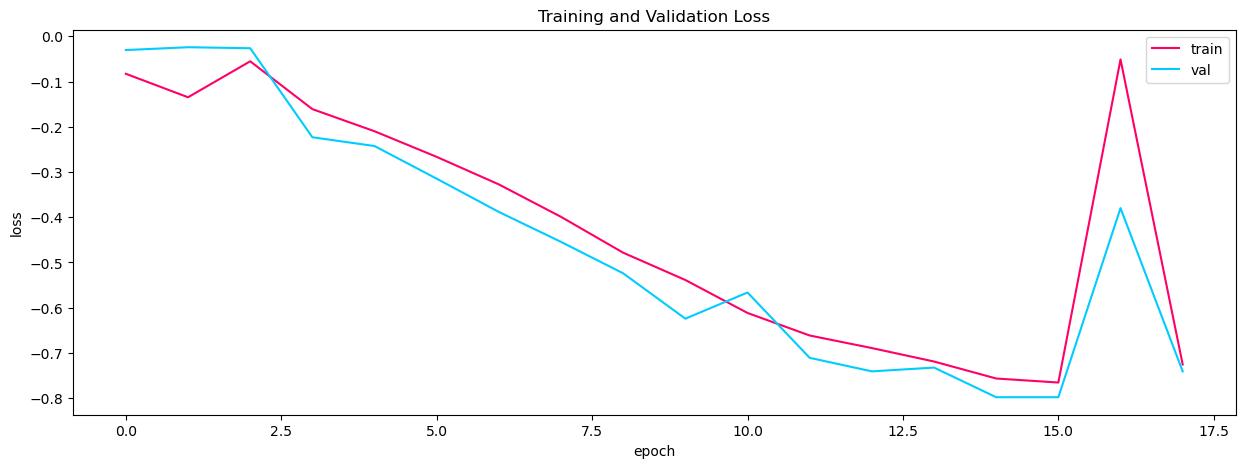

In [27]:
#-----------------------------------------------------------
acc      = history.history['dice_coef']
val_acc  = history.history['val_dice_coef']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(15,5))
plt.plot(epochs, acc, 'b', color = '#ff0066')
plt.plot(epochs, val_acc, color = '#00ccff')
plt.title ('Training and Validation Dice Similarity Coefficient')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('dice coef')
plt.xlabel('epoch');

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(15,5))
plt.plot  (epochs, loss, 'b', color = '#ff0066')
plt.plot  (epochs, val_loss, color = '#00ccff')
plt.legend(['train', 'val'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title ('Training and Validation Loss');

In [28]:
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print('Test loss: ', results[0])
print('Test IOU: ', results[2])
print('Test Dice Coefficent: ', results[3])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 5s 444ms/step - loss: -0.6847 - binary_accuracy: 0.9965 - iou: 0.5333 - dice_coef: 0.6907
Test loss:  -0.6847236752510071
Test IOU:  0.5332940816879272
Test Dice Coefficent:  0.6907110810279846


1/1 [==============================] - 0s 38ms/step


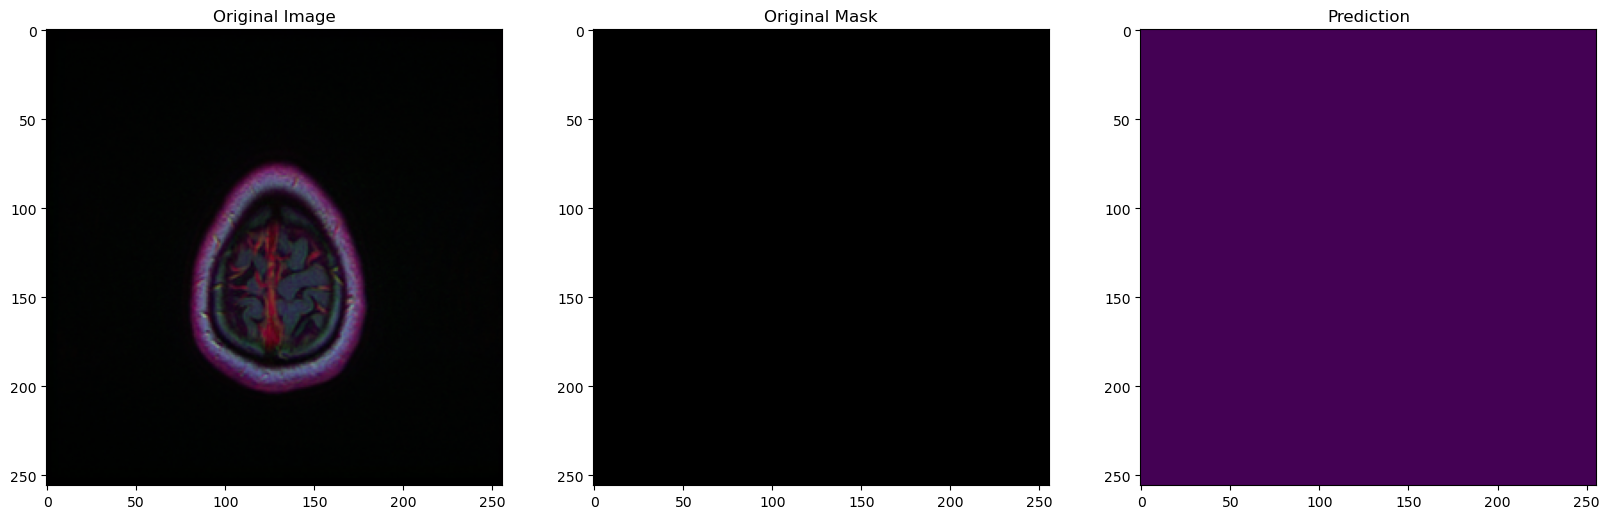

1/1 [==============================] - 0s 19ms/step


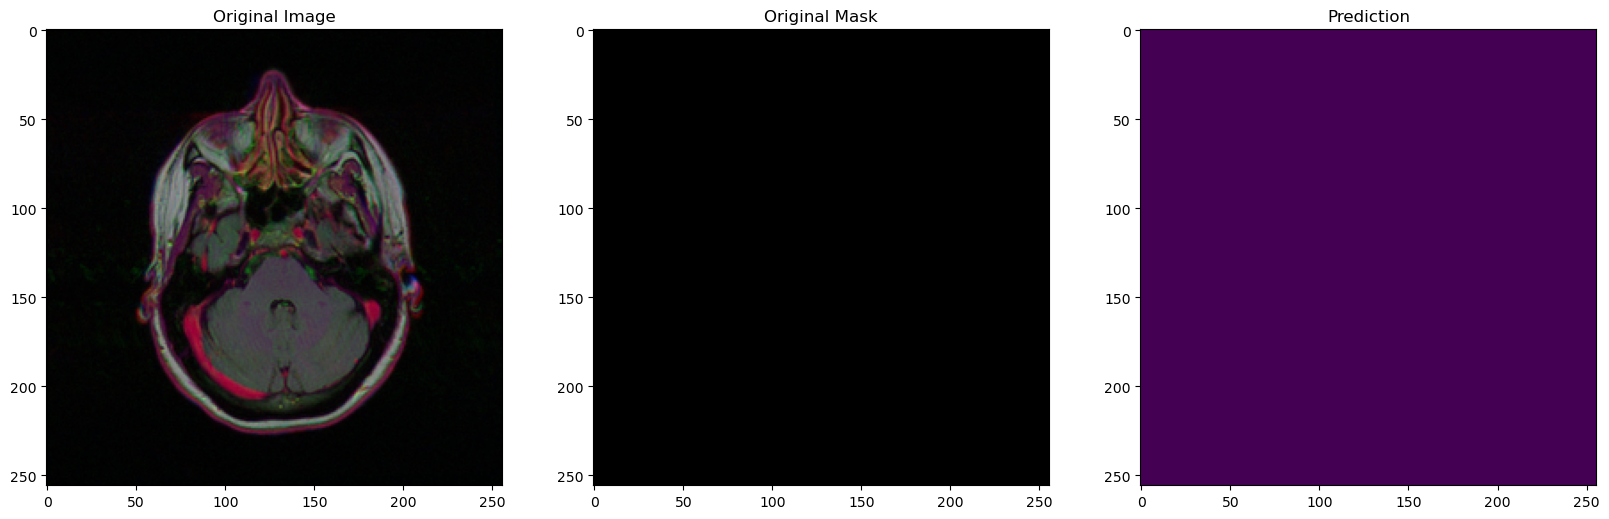

1/1 [==============================] - 0s 20ms/step


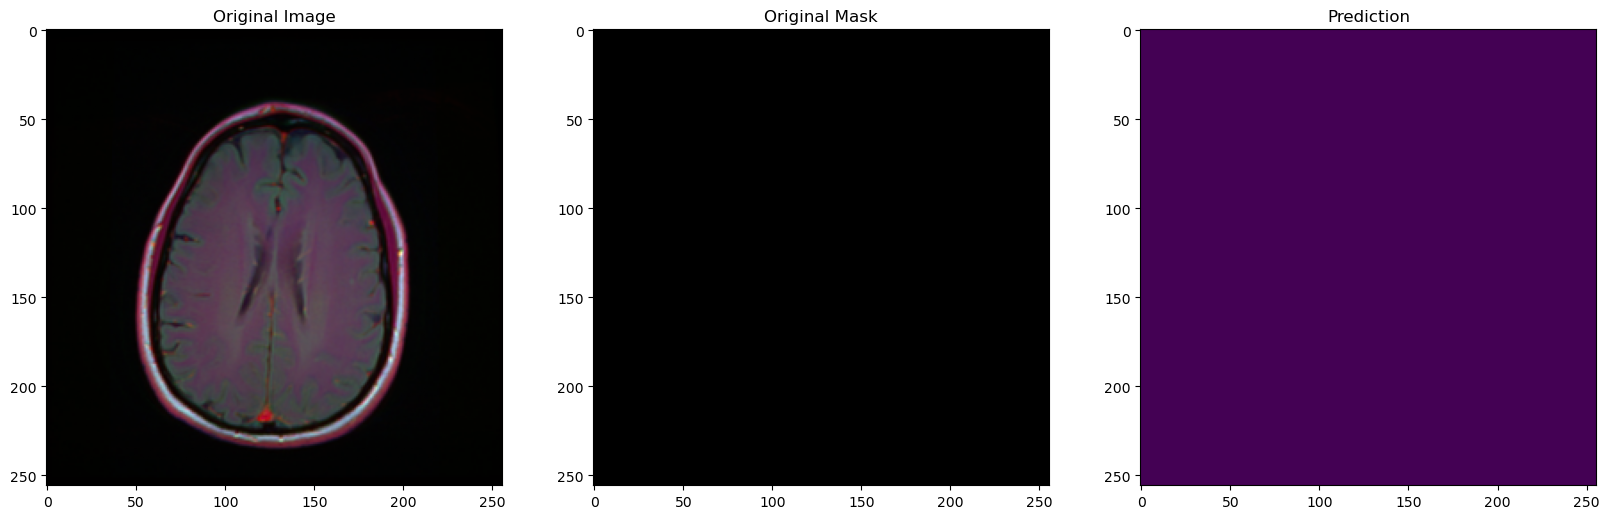

1/1 [==============================] - 0s 19ms/step


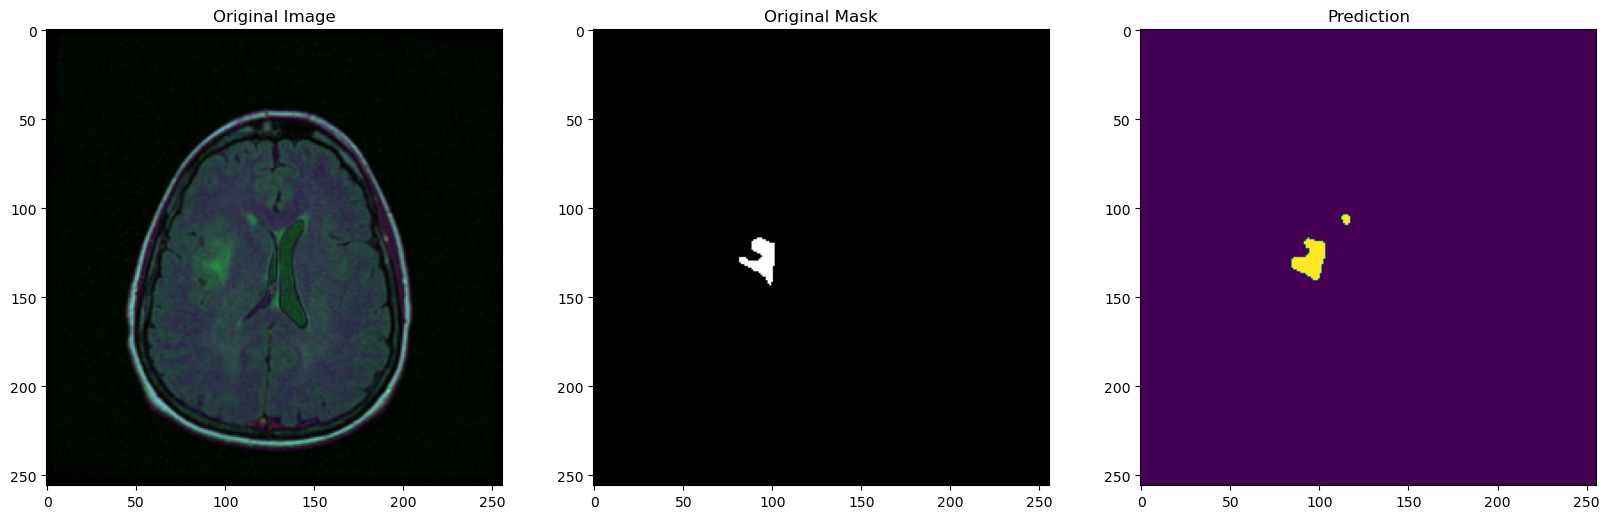

1/1 [==============================] - 0s 19ms/step


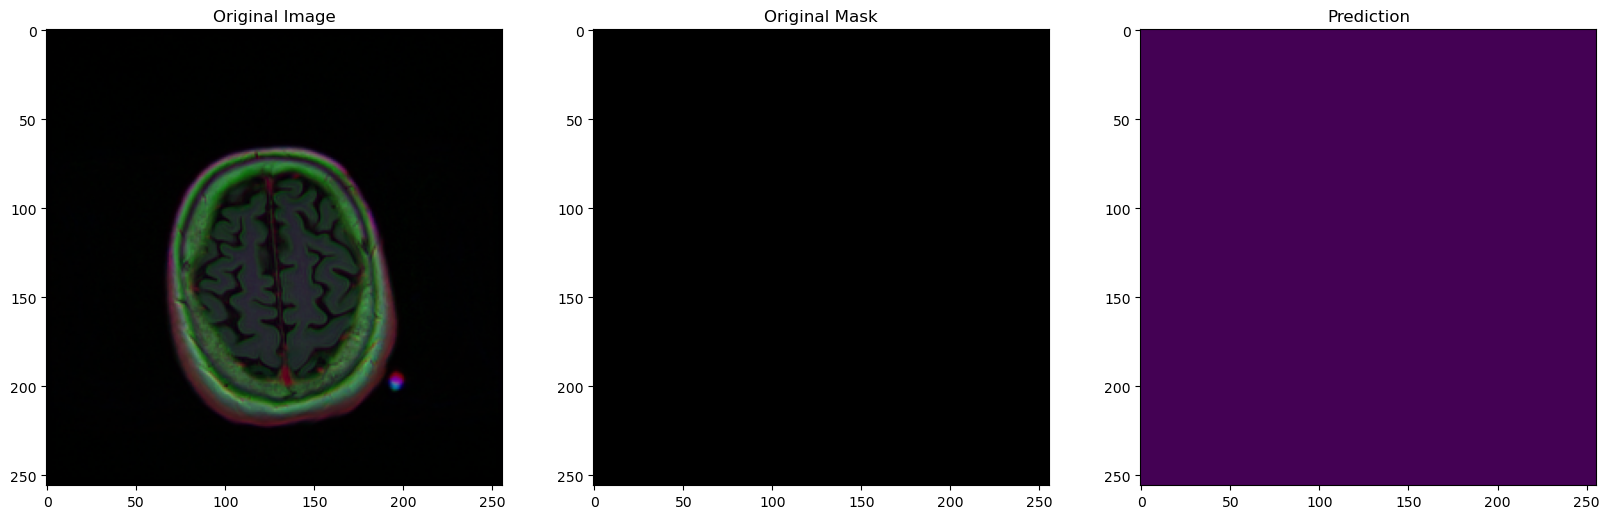

In [31]:
for i in range(5):
    index = np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred = model.predict(img)

    plt.figure(figsize=(20,50))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()